# FED_AVG

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# --- Settings ---
NUM_CLIENTS = 4
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.0 # for clarity in parameter difference being minimal
ROUNDS = 10
SEED = 42
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# --- Toy dataset (CIFAR10 subset) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



100%|██████████| 170M/170M [00:17<00:00, 9.74MB/s] 


In [4]:
data_per_client = len(train_dataset)//NUM_CLIENTS
client_datasets = random_split(train_dataset, [data_per_client]*NUM_CLIENTS)
client_loaders = [DataLoader(ds, batch_size=len(ds), shuffle=False) for ds in client_datasets]

# Centralized loader (full dataset in one batch)
central_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [6]:
# --- Utilities ---
def state_dict_to_vector(sd):
    return torch.cat([v.detach().cpu().view(-1) for v in sd.values()])

def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum/total, 100*correct/total


In [7]:
def fedsgd(global_model, client_loaders):
    criterion = nn.CrossEntropyLoss()
    global_model.to(device)
    total_data = sum(len(loader.dataset) for loader in client_loaders)

    # accumulate weighted parameters
    new_params = [torch.zeros_like(p) for p in global_model.parameters()]

    for loader in client_loaders:
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        local_model.train()

        # one step on full client dataset
        x, y = next(iter(loader))
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(local_model(x), y)
        loss.backward()
        optimizer.step()

        # weight aggregation
        Ni = len(loader.dataset)
        with torch.no_grad():
            for i, param in enumerate(local_model.parameters()):
                new_params[i] += param.data * Ni / total_data

    # update global model
    with torch.no_grad():
        for param, new_param in zip(global_model.parameters(), new_params):
            param.data = new_param.clone()

    return global_model


In [8]:
def centralized_sgd(global_model, loader):
    criterion = nn.CrossEntropyLoss()
    global_model.to(device)
    optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    global_model.train()

    # one gradient step on full dataset
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    loss = criterion(global_model(x), y)
    loss.backward()
    optimizer.step()

    return global_model

In [9]:
# --- Store metrics for visualization ---
fed_acc_list, cent_acc_list = [], []
fed_loss_list, cent_loss_list = [], []
param_diff_list = []

fed_model = SimpleCNN().to(device)
central_model = copy.deepcopy(fed_model).to(device)

for r in range(ROUNDS):
    fed_model = fedsgd(fed_model, client_loaders)
    central_model = centralized_sgd(central_model, central_loader)

    fed_loss, fed_acc = evaluate(fed_model, val_loader)
    cent_loss, cent_acc = evaluate(central_model, val_loader)

    # compute norm of parameter differences
    diff_norm = torch.norm(state_dict_to_vector(fed_model.state_dict()) -
                  state_dict_to_vector(central_model.state_dict())).item()

    # Save for plots
    fed_acc_list.append(fed_acc)
    cent_acc_list.append(cent_acc)
    fed_loss_list.append(fed_loss)
    cent_loss_list.append(cent_loss)
    param_diff_list.append(diff_norm)

    print(f"Round {r+1}: FedSGD Acc={fed_acc:.2f}, Centralized Acc={cent_acc:.2f}, ||Diff||={diff_norm:.6e}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.05 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.75 GiB is free. Process 7725 has 11.99 GiB memory in use. Of the allocated memory 11.29 GiB is allocated by PyTorch, and 579.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

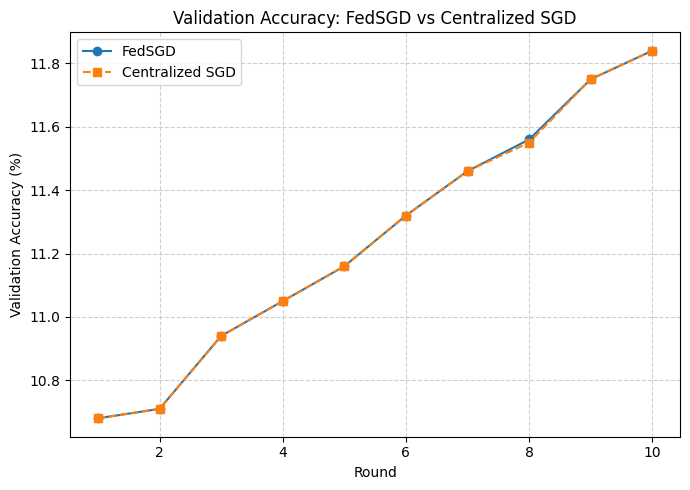

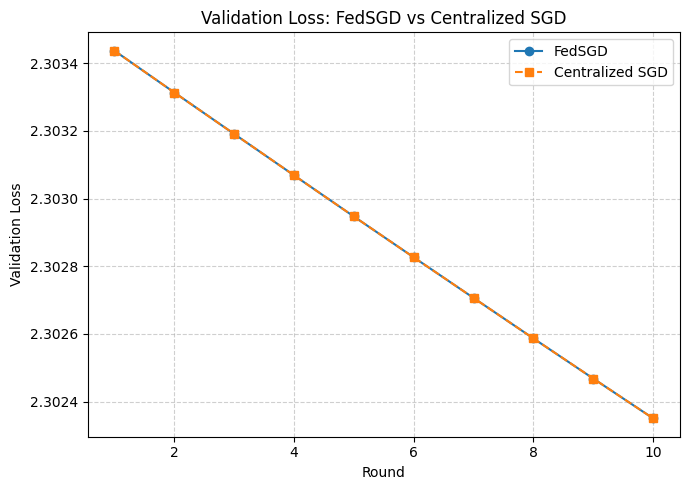

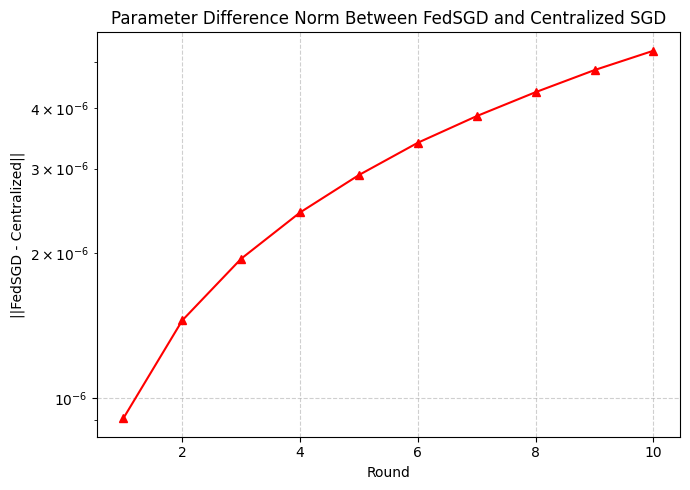

In [ ]:
# --- Plot 1: Accuracy Comparison ---
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), fed_acc_list, marker='o', linestyle='-', label='FedSGD')
plt.plot(range(1, ROUNDS+1), cent_acc_list, marker='s', linestyle='--', label='Centralized SGD')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy: FedSGD vs Centralized SGD')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Loss Comparison ---
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), fed_loss_list, marker='o', linestyle='-', label='FedSGD')
plt.plot(range(1, ROUNDS+1), cent_loss_list, marker='s', linestyle='--', label='Centralized SGD')
plt.xlabel('Round')
plt.ylabel('Validation Loss')
plt.title('Validation Loss: FedSGD vs Centralized SGD')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 3: Parameter Difference Norm ---
plt.figure(figsize=(7,5))
plt.plot(range(1, ROUNDS+1), param_diff_list, marker='^', color='r')
plt.xlabel('Round')
plt.ylabel('||FedSGD - Centralized||')
plt.title('Parameter Difference Norm Between FedSGD and Centralized SGD')
plt.yscale('log')  # Log scale for tiny differences
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
